In [41]:
import os
import sys
project_root = os.path.abspath(os.path.dirname(os.curdir))
project_root = os.path.dirname(project_root)

sys.path.append(project_root)

from ml.data.dataset import DrumDataset

data_dir = "dataset/processed"
data_dir = os.path.join(project_root, data_dir)
config_path = "config.yaml"
config_path = os.path.join(project_root, config_path)

dataset = DrumDataset(data_dir, config_path, include_genre=True)

In [42]:
item = dataset[0]
print("Item shape:", item[0].shape, item[1].shape)  #
print(len(dataset))

Item shape: torch.Size([63, 20]) torch.Size([63, 20])
434253


In [43]:
input_seq_len = 63
output_seq_len = 63
input_size = 20
output_size = 20

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import yaml
from torch.utils.data import DataLoader, Subset

# Load config to get seed
with open(os.path.join(project_root, 'config.yaml'), 'r') as f:
    config = yaml.safe_load(f)

# Set seeds for reproducibility
SEED = config['dataset']['seed']
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"Using seed: {SEED} from config file")

# Training configuration
DATASET_PERCENTAGE = 0.2  # Use 100% of dataset (change to 0.1 for 10%, 0.5 for 50%, etc.)
BATCH_SIZE = 64
EPOCHS = 1
LEARNING_RATE = 1e-3

# Check for device availability in order of preference: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: {device} (Apple Silicon GPU)")
else:
    device = torch.device('cpu')
    print(f"Using device: {device}")

class Seq2SeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, teacher_forcing_ratio=0.5):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, x, y=None, target_len=1, training=False):
        # x: (batch, input_seq_len, input_size)
        # y: (batch, target_seq_len, output_size) — only available during training
        batch_size = x.size(0)
        device = x.device

        # Encode input sequence
        _, (hidden, cell) = self.encoder(x)

        # Start decoding with last known input
        decoder_input = x[:, -1:, :]  # (batch, 1, input_size)
        outputs = []

        for t in range(target_len):
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.fc(out)  # (batch, 1, output_size)
            outputs.append(pred)

            # Decide if we use teacher forcing
            if training and y is not None and random.random() < self.teacher_forcing_ratio:
                decoder_input = y[:, t:t+1, :]  # use true value
            else:
                decoder_input = pred  # use predicted value

        return torch.cat(outputs, dim=1)  # (batch, target_len, output_size)

# Create subset of dataset based on percentage using config seed for reproducibility
dataset_size = len(dataset)
subset_size = int(dataset_size * DATASET_PERCENTAGE)

# Use seeded random generator for consistent sampling
generator = torch.Generator().manual_seed(SEED)
indices = torch.randperm(dataset_size, generator=generator)[:subset_size]
subset_dataset = Subset(dataset, indices)

print(f"Original dataset size: {dataset_size}")
print(f"Using {DATASET_PERCENTAGE*100}% of dataset: {subset_size} samples")
print(f"Subset created with seed {SEED} for reproducible sampling")

dataloader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = Seq2SeqRNN(
    input_size=20,
    hidden_size=32,
    output_size=20,
    teacher_forcing_ratio=0.5
).to(device)  # Move model to GPU/CPU

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting training...")
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (X, Y) in enumerate(dataloader):
        # Move data to device
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        output = model(X, Y, target_len=Y.shape[1], training=True)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(dataloader)}, Current Loss: {loss.item():.6f}", end='\r')

    avg_loss = total_loss / len(dataloader)
    print(f"\nEpoch {epoch+1}/{EPOCHS} completed - Average Loss: {avg_loss:.6f}")

Using seed: 42 from config file
Using device: mps (Apple Silicon GPU)
Original dataset size: 434253
Using 20.0% of dataset: 86850 samples
Subset created with seed 42 for reproducible sampling
Starting training...
Epoch 1/1, Batch 1350/1358, Current Loss: 0.006732
Epoch 1/1 completed - Average Loss: 0.011483

Epoch 1/1 completed - Average Loss: 0.011483


In [52]:
#get a sample that has not been used in training
sample_idx = subset_size  # First index outside the training subset
sample = dataset[sample_idx]
X_sample = sample[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
Y_sample = sample[1].unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    future_steps = model(X_sample, target_len=Y_sample.shape[1], training=False)

/var/folders/wm/x7thdv3x0xn_c4_dr0tktpj80000gn/T/ipykernel_98712/2514866369.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


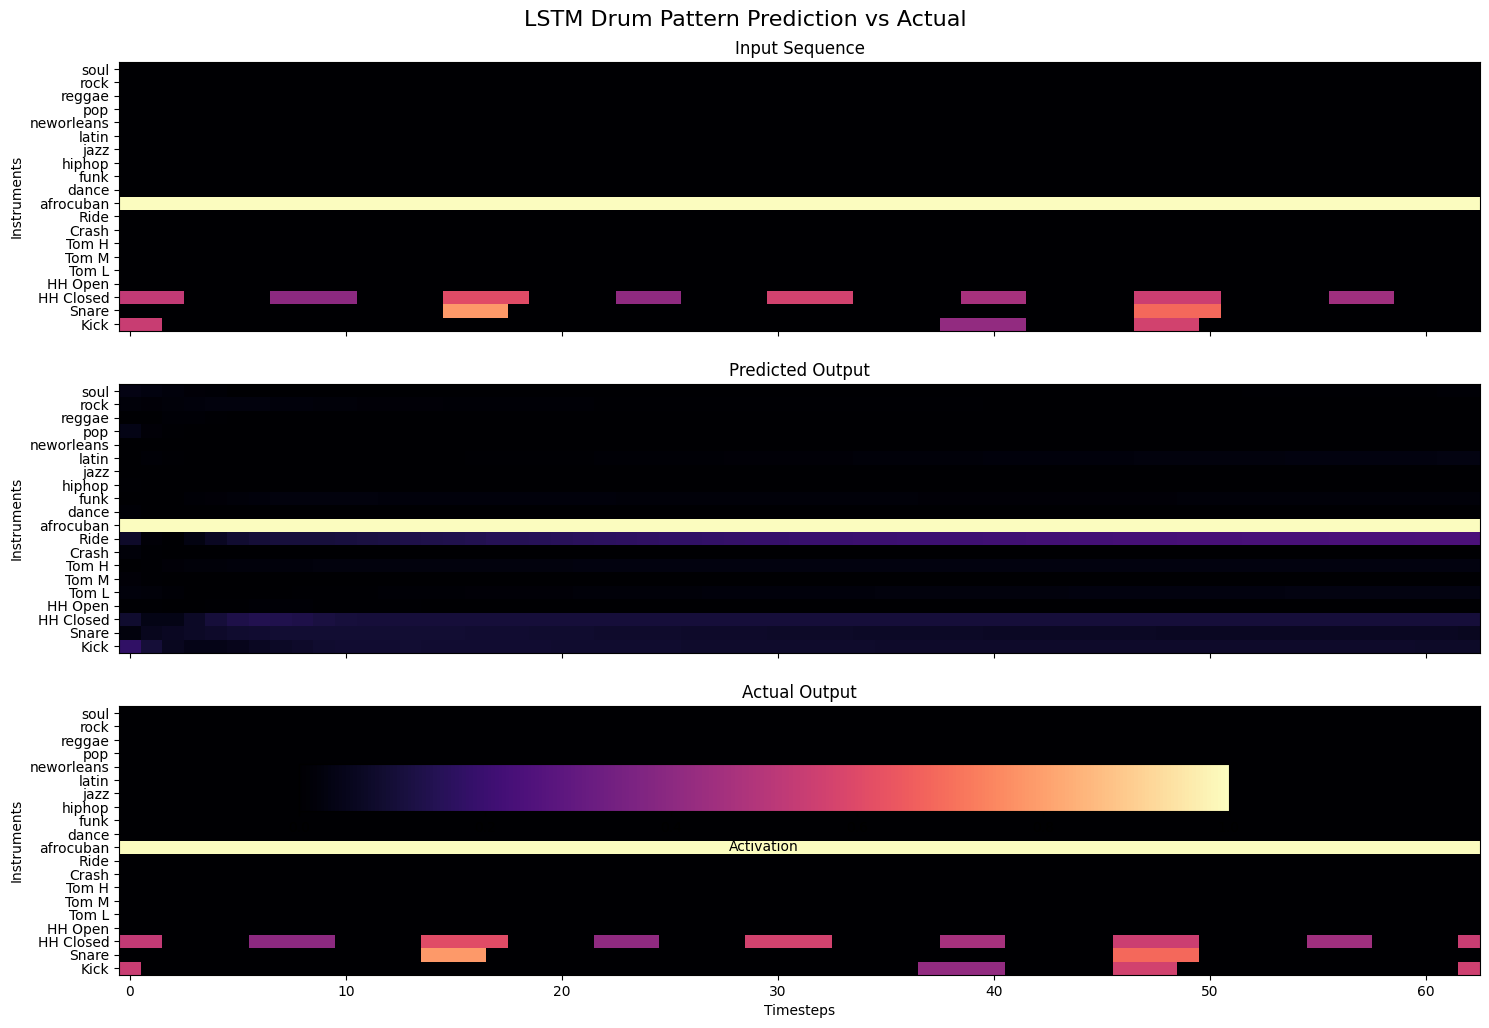


Prediction Statistics:
Mean Squared Error: 0.010127
Mean Absolute Error: 0.045689
Input sequence shape: (63, 20)
Predicted sequence shape: (63, 20)
Actual sequence shape: (63, 20)


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from tensors
predicted = future_steps.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy
actual = Y_sample.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy
input_seq = X_sample.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy

# Define instrument names (based on your dataset configuration)
base_instruments = [
    "Kick",
    "Snare", 
    "HH Closed",
    "HH Open",
    "Tom L",
    "Tom M", 
    "Tom H",
    "Crash",
    "Ride"
]

# Check if we have genre information (20 features total means 9 instruments + 11 genres)
num_features = predicted.shape[1]
if num_features > len(base_instruments) and hasattr(dataset, 'genres'):
    instruments = base_instruments + dataset.genres
else:
    instruments = base_instruments[:num_features]  # Use only the available instruments

# Create the comparison plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig.suptitle('LSTM Drum Pattern Prediction vs Actual', fontsize=16)

# Plot input sequence
im1 = axes[0].imshow(input_seq.T, aspect="auto", origin="lower", cmap="magma", vmin=0, vmax=1)
axes[0].set_yticks(range(len(instruments)))
axes[0].set_yticklabels(instruments)
axes[0].set_ylabel("Instruments")
axes[0].set_title("Input Sequence")

# Plot predicted sequence  
im2 = axes[1].imshow(predicted.T, aspect="auto", origin="lower", cmap="magma", vmin=0, vmax=1)
axes[1].set_yticks(range(len(instruments)))
axes[1].set_yticklabels(instruments)
axes[1].set_ylabel("Instruments")
axes[1].set_title("Predicted Output")

# Plot actual sequence
im3 = axes[2].imshow(actual.T, aspect="auto", origin="lower", cmap="magma", vmin=0, vmax=1)
axes[2].set_yticks(range(len(instruments)))
axes[2].set_yticklabels(instruments)
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Instruments")
axes[2].set_title("Actual Output")

# Add colorbar
plt.colorbar(im3, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8, label='Activation')

plt.tight_layout()
plt.show()

# Print some statistics
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(np.abs(predicted - actual))
print(f"\nPrediction Statistics:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"Input sequence shape: {input_seq.shape}")
print(f"Predicted sequence shape: {predicted.shape}")
print(f"Actual sequence shape: {actual.shape}")